# Lens fit

In [1]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cms
%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import lenstronomy.Plots.output_plots as lens_plot
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

import copy

In [2]:
def ADD(z1,z2):
    ## This is a function that computes the angular diameter distance
    ## between two redshifts z1 and z2.
    cosmo = FlatLambdaCDM(H0=70, Om0=0.316) 
    return cosmo.angular_diameter_distance_z1z2(z1,z2)

def sigma_cr(zd,zs):
    ## This function calculates the critical surface mass density at
    ## redshift zd, relative to the source redshift zs.
    const = 1.663e18*u.M_sun / u.Mpc##c^2/(4 pi G)
    return const*(ADD(0,zs)/(ADD(zd,zs)*ADD(0,zd))) ##in units Msun/Mpc^2

def gfunc(c):
    ## This is the g(c) function that is defined
    ## commonly in NFW profiles.
    a = np.log(1.+c) - (c/(1.+c))
    return 1./a

def rs_angle(zd,rs): 
    ##takes in interloper redshift, gives you the scale redius in angular units
    Dd = ADD(0,zd)
    rs_mpc = rs*u.Mpc
    return ((1./4.848e-6)*rs_mpc)/Dd ##gives in arcsec

def alpha_s(m,rs,zd,zs):
    ##takes in subhalo mass, scale radius, interloper redshift, source redshift
    ##returns the angular deflection at scale radius
    m_msun = m*u.M_sun
    rs_mpc = rs*u.Mpc
    con = (1./np.pi)*gfunc(200.)*(1.-np.log(2))
    return m_msun/((rs_mpc**2.)*sigma_cr(zd,zs))

def k_ext(N,m,A,zd,zs,pixsize):
    ## FOR NOW THIS IS SET TO ZERO BECAUSE I CAN'T GET IT TO WORK
    m_msun = m*u.M_sun
    A_mpc2 = (pixsize**4)*(ADD(0.,zd)**2.)*A*((4.848e-6)**2.)  ##arcsec conversion
    return 0.##-(N*m_msun)/(A_mpc2*sigma_cr(zd,zs))


def xi_to_x(xi,z):
    ##takes in physical coordinates (Mpc), turns it into angular coordinates (arcsec)
    x = np.array(((xi*u.Mpc)/ADD(0.,z))/4.848e-6)
    y = x.astype(np.float)
    return y

def x_to_xi(x,z):
    ##takes in angular coordinates (arcsec), turns it into physical coordinates (Mpc)
    return ((x*4.848e-6)*ADD(0,z))/u.Mpc

def xi_to_pix(xi,z,pixsize,pixnum):
    ## takes in physical coordinates (Mpc), identifies the appropriate pixel number
    return (xi_to_x(xi,z))/pixsize + pixnum/2.

# Generate image

In [3]:
## REDSHIFTS #######################################################################################
Nit = 100 ##Number of different redshifts
zds = np.linspace(0.01,0.99,Nit)
####################################################################################################



## SOURCE PROPERTIES ###############################################################################
r_sersic_source = 10.0
e1s, e2s = param_util.phi_q2_ellipticity(phi=0.8, q=0.2)
beta_ras, beta_decs = [1.7],[0.3]#this is the source position on the source plane

n_sersic_source = 1.5

## SOURCE-CLUMP PROPERTIES #########################################################################
r_sersic_source_clumps = 1/3.
N_clump = 0
clumprandx = np.random.rand(N_clump)
clumprandy = np.random.rand(N_clump)

source_scatter = 1. ## This is how wide the scatter of the clumps over the smooth source

n_sersic_source_clumps = 1.5

####################################################################################################



## LENS PROPERTIES #################################################################################
theta_lens = 10.
zl = 0.2
r_theta_lens = x_to_xi(theta_lens,zl)
e1, e2 = param_util.phi_q2_ellipticity(phi=-0.9, q=0.8)
gamma = 2.

center_lens_x, center_lens_y = 0.,0.
####################################################################################################



## IMAGE PROPERTIES ################################################################################
pixsize = 0.2
####################################################################################################



## INTERLOPER PROPERTIES ########################################################################### 
N = 1 ##Number of perturbers
M = 1 ##Averaging different realizations

disc_size = 2. ##  interlopers are randomly distributed to a disk that is this
               ##  this times bigger than the einstein radius of the lens
# Perturbers are uniformly distributed within a disk of radius `disc_size * r_theta_lens`
r2s = ((disc_size*r_theta_lens)**2.)*(np.random.rand(N,M))
rss = np.sqrt(r2s)
theta_p = 2.*np.pi*(np.random.rand(N,M))
xs = rss*np.cos(theta_p)
ys = rss*np.sin(theta_p)
xpixs = np.zeros([Nit,N,M]) # will add pixel values in the next cell
ypixs = np.zeros([Nit,N,M]) #
####################################################################################################

In [89]:
imagesz = []  ##This will be the main list that all the images that are created are added
              ##at the end it will have the shape (Number of redshifts, Number of statistics,x-Pix,y-Pix)
for j in range(Nit): ## FIRST LOOP IS OVER THE REDSHIFTS
    
    imagesM = []  ## this is a sub-list of imagesz that will be of shape (Number of statistics,x-Pix,y-Pix)
    
    xpixs[j] = xi_to_pix(xs,zds[j],pixsize,200)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
    ypixs[j] = xi_to_pix(ys,zds[j],pixsize,200)   ## POSITIONS. (THEY ARE RANDOMLY GENERATED IN THE EARLIER BOX)
    
    for k in range(M):   ## SECOND LOOP IS OVER THE STATISTICS
        m =1.0e7#ms[j] # mass of interlopers
        if j == 0:
            m = 0.
        zs = 1.
        zd = zds[j] # interloper redshift
        rs = 0.001  # interloper scale radius r_s
        A = 80**2 ## in arcsec ## IGNORE THIS, THIS WAS FOR NEGATIVE CONVERGENCE
        # pixsize = 0.2 (this was already defined above)
        
        

        kext = float(k_ext(N,m,A,zl,zs,pixsize))
        rsang = float(rs_angle(zd,rs))
        alphars = float(alpha_s(m,rs,zd,zs))

        ## Setting lens_model_list and redshift_list
        lens_model_main = ['SPEP']
        lens_model_interlopers = ['CONVERGENCE']+['NFW' for i in range(N)]
        redshift_main = [zl]
        redshift_interlopers = [zd]+[zd for i in range(N)]
        # (unfortunately, we need to give the redshifts in increasing order, so we have two cases)
        if zl >= zd:
            lens_model_list = lens_model_interlopers + lens_model_main
            redshift_list = redshift_interlopers + redshift_main
        else:
            lens_model_list = lens_model_main + lens_model_interlopers
            redshift_list = redshift_main + redshift_interlopers
      
        
        z_source = zs
    
        lensModel_mp = LensModel(lens_model_list=lens_model_list,
                              z_source=z_source, lens_redshift_list=redshift_list, 
                              multi_plane=True)

        kwargs_spep = {'theta_E': theta_lens, 'e1': e1, 'e2': e2, 
                       'gamma': gamma, 'center_x': center_lens_x, 'center_y': center_lens_y}
        kwargs_conv ={'kappa_ext': kext}

        ### Populate kwargs of interlopers (as NFW distributions)
        kwargs_main_lens = [kwargs_spep]
        kwargs_interlopers = [kwargs_conv] # (will append more)
        for i in range(N):
            center_nfw_x = xi_to_x(xs[i,k],zd)
            center_nfw_y = xi_to_x(ys[i,k],zd)
            
            kwargs_nfw = {'Rs':rsang,'alpha_Rs':alphars,'center_x': center_nfw_x, 'center_y': center_nfw_y}
            ##param_names = ['Rs', 'alpha_Rs', 'center_x', 'center_y']
            kwargs_interlopers.append(kwargs_nfw)
        
        # (again, need to sort by redshift)
        if zl >= zd:
            kwargs_lens = kwargs_interlopers + kwargs_main_lens
        else:
            kwargs_lens = kwargs_main_lens + kwargs_interlopers
        
        # image plane coordinate #
        beta_ra, beta_dec = beta_ras[0],beta_decs[0]#0.,0.#0.03425921, 0.012145

        solver = LensEquationSolver(lensModel_mp)
        theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

        mag = lensModel_mp.magnification(theta_ra, theta_dec, kwargs_lens)
        dt = lensModel_mp.arrival_time(theta_ra, theta_dec, kwargs_lens)
        ########################################################################
        # set up the list of light models to be used #
        
        source_light_model_list = ['SERSIC_ELLIPSE']
        
        
        for i in range(N_clump):
            source_light_model_list.append('SERSIC')
        
        lightModel_source = LightModel(light_model_list=source_light_model_list)
        lens_light_model_list = ['SERSIC_ELLIPSE']
        lightModel_lens = LightModel(light_model_list=lens_light_model_list)
        # define the parameters #
#        kwargs_light_source = [{'amp': 1000, 'R_sersic': r_sersic_source , 'n_sersic': 1.5, 
#                                'center_x': beta_ra, 'center_y': beta_dec}]
        
        kwargs_light_source = [{'amp': 0., 'R_sersic': r_sersic_source, 'n_sersic': n_sersic_source, 
                              'e1': e1s, 'e2': e2s, 'center_x': beta_ra , 'center_y': beta_dec}]
        
        for i in range(N_clump):
            kwargs_light_source.append({'amp': 1000, 'R_sersic': r_sersic_source_clumps, 'n_sersic': n_sersic_source_clumps, 
                                'center_x': beta_ra+source_scatter*(clumprandx[i]-.5), 
                                        'center_y': beta_dec+source_scatter*(clumprandy[i]-.5)})
        
        
        kwargs_light_lens = [{'amp': 1500, 'R_sersic': theta_lens, 'n_sersic': gamma, 
                              'e1': e1, 'e2': e2, 'center_x': center_lens_x , 'center_y': center_lens_y}]

        # evaluate surface brightness at a specific position #
        flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

        
        deltaPix = pixsize ###aLSO PIXSIze size of pixel in angular coordinates #

        # setup the keyword arguments to create the Data() class #
        ra_at_xy_0, dec_at_xy_0 = -20, -20 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
        transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
        kwargs_pixel = {'nx': 200, 'ny': 200,  # number of pixels per axis
                        'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                        'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                        'transform_pix2angle': transform_pix2angle} 
        pixel_grid = PixelGrid(**kwargs_pixel)
        # return the list of pixel coordinates #
        x_coords, y_coords = pixel_grid.pixel_coordinates
        # compute pixel value of a coordinate position #
        x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
        # compute the coordinate value of a pixel position #
        ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

        # import the PSF() class #
        
        kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
                      'fwhm': 0.01,  # full width at half maximum of the Gaussian PSF (in angular units)
                      'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
                     }
        psf = PSF(**kwargs_psf)
        # return the pixel kernel correspon
        kernel = psf.kernel_point_source

        ####################################################################################

        # import the ImageModel class #
        
        # define the numerics #
        kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                          'supersampling_convolution': False}
        # initialize the Image model class by combining the modules we created above #
        imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_mp,
                                source_model_class=lightModel_source,
                                lens_light_model_class=lightModel_lens,
                                #point_source_class=pointSource, 
                                kwargs_numerics=kwargs_numerics)
        # simulate image with the parameters we have defined above #
        image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                                 kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)
        imagesM.append(image)
        
    imagesz.append(imagesM)
    if j % 5 == 0:
        print(j) ##tells you the progress

np.save('github_test_image.npy',imagesz)
np.save('github_test_XPIX.npy',xpixs)
np.save('github_test_image_YPIX.npy',ypixs)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [4]:
print(np.shape(imagesz))
print(np.shape(xpixs)) ## interloper positions
print(np.shape(ypixs)) ## interloper positions

NameError: name 'imagesz' is not defined

# Fit with MCMC

The idea here is that we will use MCMC to fit our image to a single-plane model. In particular, for now, we have one interloper, and we're varying only the position.

*(work in progress)*

(15, 20)

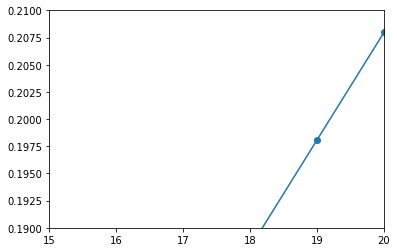

In [4]:
plt.plot(zds, 'o-')
plt.ylim(.19,.21)
plt.xlim(15,20)

In [5]:
zds[19]

0.19808080808080808

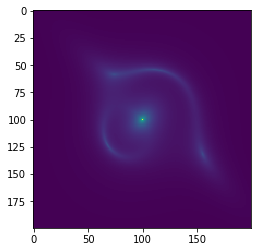

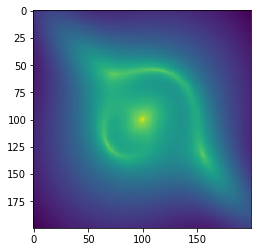

In [6]:
j = 19 # arbitrary choice (loop over redshifts)
k = 0 # also arbitrary choice (loop over statistics)

beta_ra, beta_dec = beta_ras[0], beta_decs[0]

xpixs[j] = xi_to_pix(xs,zds[j],pixsize,200)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
ypixs[j] = xi_to_pix(ys,zds[j],pixsize,200)   ## POSITIONS. (THEY ARE RANDOMLY GENERATED IN THE EARLIER BOX)

m =1.0e7 # mass of interlopers
if j == 0:
    m = 0. # so that the first image will be pure (no interloper effect)
zs = 1.
zd = zds[j] # interloper redshift
rs = 0.001  # interloper scale radius r_s
A = 80**2 ## in arcsec ## IGNORE THIS, THIS WAS FOR NEGATIVE CONVERGENCE

kext = float(k_ext(N,m,A,zl,zs,pixsize))
rsang = float(rs_angle(zd,rs))
alphars = float(alpha_s(m,rs,zd,zs))

## Setting lens_model_list and redshift_list
lens_model_main = ['SPEP']
lens_model_interlopers = ['CONVERGENCE']+['NFW' for i in range(N)]
redshift_main = [zl]
redshift_interlopers = [zd]+[zd for i in range(N)]
# (unfortunately, we need to give the redshifts in increasing order, so we have two cases)
if zl >= zd:
    lens_model_list = lens_model_interlopers + lens_model_main
    redshift_list = redshift_interlopers + redshift_main
else:
    lens_model_list = lens_model_main + lens_model_interlopers
    redshift_list = redshift_main + redshift_interlopers


z_source = zs

lensModel_mp = LensModel(lens_model_list=lens_model_list,
                         z_source=z_source,
                         lens_redshift_list=redshift_list, 
                         multi_plane=True)

kwargs_spep = {'theta_E': theta_lens, 'e1': e1, 'e2': e2, 
               'gamma': gamma, 'center_x': center_lens_x, 'center_y': center_lens_y}
kwargs_conv ={'kappa_ext': kext}

### NFW kwargs for the interlopers
kwargs_main_lens = [kwargs_spep]
kwargs_interlopers = [kwargs_conv] # (+ will append interlopers)
for i in range(N):
    center_nfw_x = xi_to_x(xs[i,k],zd)
    center_nfw_y = xi_to_x(ys[i,k],zd)

    kwargs_nfw = {'Rs':rsang,'alpha_Rs':alphars,'center_x': center_nfw_x, 'center_y': center_nfw_y}
    kwargs_interlopers.append(kwargs_nfw)

# (again, need to sort by redshift)
if zl >= zd:
    kwargs_lens = kwargs_interlopers + kwargs_main_lens
else:
    kwargs_lens = kwargs_main_lens + kwargs_interlopers

########################################################################
# set up the list of light models to be used #

# SOURCE light
source_light_model_list = ['SERSIC_ELLIPSE']
for i in range(N_clump):
    source_light_model_list.append('SERSIC')

lightModel_source = LightModel(light_model_list = source_light_model_list)

# LENS light
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list = lens_light_model_list)

# SOURCE light kwargs
kwargs_light_source = [{'amp': 1000., 'R_sersic': r_sersic_source, 'n_sersic': n_sersic_source, 
                      'e1': e1s, 'e2': e2s, 'center_x': beta_ra , 'center_y': beta_dec}]
for i in range(N_clump):
    kwargs_light_source.append({'amp': 1000, 'R_sersic': r_sersic_source_clumps, 'n_sersic': n_sersic_source_clumps,
                                'center_x': beta_ra+source_scatter*(clumprandx[i]-.5), 
                                'center_y': beta_dec+source_scatter*(clumprandy[i]-.5)})

# LENS light kwargs
kwargs_light_lens = [{'amp': 1500, 'R_sersic': theta_lens, 'n_sersic': gamma, 
                      'e1': e1, 'e2': e2, 'center_x': center_lens_x , 'center_y': center_lens_y}]

# evaluate surface brightness at a specific position #
#flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

deltaPix = pixsize ###aLSO PIXSIze size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -20, -20 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 200, 'ny': 200,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #

kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.01,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel correspon
kernel = psf.kernel_point_source

####################################################################################

# import the ImageModel class #

# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_mp,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)

plt.imshow(image); plt.show()
plt.imshow(np.log(image)); plt.show()

In [7]:
## Noisy Image #####################################################################
exp_time = 100  # exposure time to quantify the Poisson noise level (what units?)
background_rms = 0.1  # background rms value
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson
# plt.imshow(image_noisy); plt.show()
# plt.imshow(np.log(image_noisy)); plt.show()

## Observational kwargs
`kwargs_data_joint` seems to be about observational effects.

In [8]:
kwargs_data = {'image_data': image_noisy,
               'background_rms': background_rms,
               'exposure_time': exp_time,
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle}
single_band = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': single_band, 'multi_band_type': 'multi-linear'} 

## Parameters
What are the parameters we have to fit?

In [9]:
def get_mcmc_kwargs_lens():
    # returns kwargs_lens-related list of dictionaries for MCMC
    
    # secretly a function of e1, e2, rsang, alphars, theta_lens, kext, gamma
    
    # Remember:
    # 0: init, 1: sigma, 2: fixed, 3: lower, 4: upper !
    
    # We will set up the list for each type of lens like this:
    spep = [{} for _ in range(5)]
    conv = [{} for _ in range(5)]
    interloper = [None]*5

    spep[2] = {'center_x': 0.0,
      'center_y': 0.0,
      'e1': e1,
      'e2': e2,
      'gamma': gamma,
      'theta_E': theta_lens}
    conv[2] = {'kappa_ext': kext, 'ra_0':0, 'dec_0':0}
    interloper[2] = {'Rs': rsang, 'alpha_Rs':alphars}
    interloper[0] = {'center_x':0, 'center_y':0}
    interloper[1] = {'center_x':6, 'center_y':6}
    interloper[3] = {'center_x':-20, 'center_y':-20}
    interloper[4] = {'center_x':20, 'center_y':20}
    
    if zd >= zl: # main lens in front of interlopers
        return [[spep[i], conv[i]]+[interloper[i] for _ in range(N)]
                    for i in range(5)]
    else:
        return [[interloper[i] for _ in range(N)]+[spep[i], conv[i]]
                    for i in range(5)]

In [10]:
def get_mcmc_kwargs_light_source():
    # returns a kwargs_light_source-related list
    #   of dictionaries as input for MCMC
    
    # secret inputs: (to fill in later)
    
    # Remember:
    # 0: init, 1: sigma, 2: fixed, 3: lower, 4: upper !
    
    main = [{} for _ in range(5)]
    clump = [{} for _ in range(5)]
    
    main[2] = {'R_sersic': r_sersic_source,
          'amp': 1000,
          'center_x': beta_ra,
          'center_y': beta_dec,
          'e1': e1s,
          'e2': e2s,
          'n_sersic': n_sersic_source}
    
    clump[2] = {'R_sersic': r_sersic_source_clumps,
                'amp':0,
                'n_sersic': 1.5}
    
    clump[0] = {'center_x': beta_ra, 'center_y': beta_dec}
    clump[1] = {'center_x': source_scatter, 'center_y': source_scatter}
    clump[3] = {'center_x': -10, 'center_y': -10}
    clump[4] = {'center_x': 10, 'center_y': 10}
    
    if zd >= zl:
        return [[clump[i] for _ in range(N_clump)]+[main[i]] for i in range(5)]
    else:
        return [[main[i]]+[clump[i] for _ in range(N_clump)] for i in range(5)]

In [11]:
def get_mcmc_kwargs_light_lens():
    # returns a kwargs_light_lens-related list of dicts as input for MCMC
    
    # secret inputs: (to fill in later)
    
    # Remember:
    # 0: init, 1: sigma, 2: fixed, 3: lower, 4: upper !
    
    light = [{} for _ in range(5)]
    
    light[2] = {'R_sersic': theta_lens,
          'amp': 1500,
          'center_x': 0.0,
          'center_y': 0.0,
          'e1': e1,
          'e2': e2,
          'n_sersic': gamma}
    
    return [light]

## Other kwargs

In [12]:
kwargs_params = {'lens_model': get_mcmc_kwargs_lens(),
                 'source_model': get_mcmc_kwargs_light_source(),
                 'lens_light_model': get_mcmc_kwargs_light_lens()}
kwargs_constraints = {}
kwargs_likelihood = {'source_marg':False}

kwargs_model = {'lens_model_list':lens_model_list, 'source_light_model_list':source_light_model_list}

## Fitting Seq

In [13]:
sandbox_kwargs_params = {'lens_model': [[{'Rs': 50,
    'alpha_Rs': 5,
    'r_trunc': 50,
    'center_x': 0,
    'center_y': 0},
   {'Rs': 5, 'alpha_Rs': 0.2, 'r_trunc': 5, 'center_x': 0.3, 'center_y': 0.3}],
  [{'Rs': 10, 'alpha_Rs': 1, 'r_trunc': 10, 'center_x': 0.5, 'center_y': 0.5},
   {'Rs': 1,
    'alpha_Rs': 0.04,
    'r_trunc': 1,
    'center_x': 0.5,
    'center_y': 0.5}],
  [{}, {}],
  [{'Rs': 1, 'alpha_Rs': 0.01, 'r_trunc': 1, 'center_x': -2, 'center_y': -2},
   {'Rs': 0.1,
    'alpha_Rs': 0.001,
    'r_trunc': 0.1,
    'center_x': -2,
    'center_y': -2}],
  [{'Rs': 500, 'alpha_Rs': 50, 'r_trunc': 500, 'center_x': 2, 'center_y': 2},
   {'Rs': 50, 'alpha_Rs': 20, 'r_trunc': 50, 'center_x': 2, 'center_y': 2}]],
 'source_model': [[{'amp': 50000,
    'R_sersic': 0.02,
    'n_sersic': 1.5,
    'center_x': 0,
    'center_y': 0}],
  [{'amp': 5000,
    'R_sersic': 0.002,
    'n_sersic': 0.15,
    'center_x': 0.1,
    'center_y': 0.1}],
  [{}],
  [{'amp': 1000,
    'R_sersic': 0.002,
    'n_sersic': 0.3,
    'center_x': -2,
    'center_y': -2}],
  [{'amp': 100000,
    'R_sersic': 0.2,
    'n_sersic': 10,
    'center_x': 2,
    'center_y': 2}]]}

In [14]:
lens_model_list

['CONVERGENCE', 'NFW', 'SPEP']

In [15]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
                              kwargs_constraints, kwargs_likelihood, kwargs_params)

In [16]:
%%time
fitting_kwargs_list = [['MCMC', {'n_burn':1, 'n_run':300, 'walkerRatio':10, 'sigma_scale':.1}]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

KeyError: 'kappa_ext'

In [181]:
# import pickle

# with open('chains.p', 'wb') as f:
#     pickle.dump(chain_list, f)

In [182]:
chain_list

[['EMCEE', array([[ 0.58027264,  0.00981508],
         [ 2.21022243, -0.92517177],
         [ 0.6232737 ,  1.02508645],
         ...,
         [-8.51953316,  5.77215827],
         [-8.51422438,  5.78466367],
         [ 3.79548901, -3.44751715]]), ['center_x_lens2',
   'center_y_lens2'], array([-2.08978142e+09, -2.08952210e+09, -2.08960352e+09, ...,
         -2.08840160e+09, -2.08840160e+09, -2.08815108e+09])]]

0 center_x_lens2


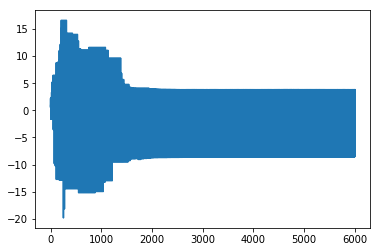

1 center_y_lens2


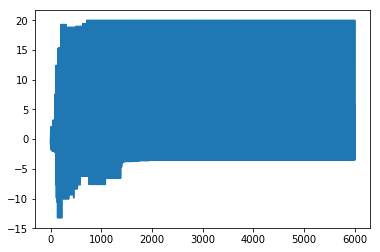

In [183]:
for i, var in enumerate(chain_list[0][2]):
    print(i, var)
    plt.plot(chain_list[0][1][:,i])
    plt.show()

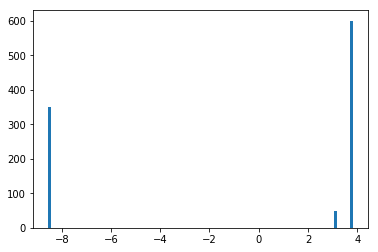

In [210]:
plt.hist(chain_list[0][1][-1000:,0], bins=100)
plt.show()

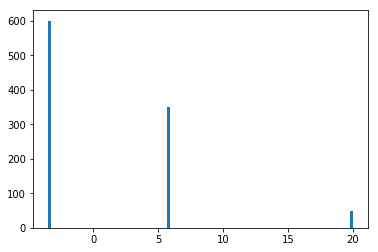

In [211]:
plt.hist(chain_list[0][1][-1000:,1], bins=100)
plt.show()

In [212]:
len(chain_list[0][1][:,0])

6000

(-20, 20)

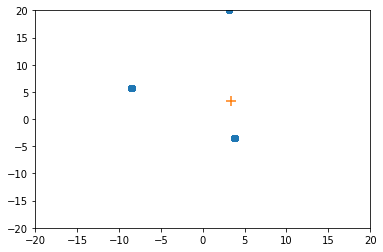

In [213]:
plt.scatter(chain_list[0][1][-1000:,0], chain_list[0][1][-1000:,1])


for i in range(N):
    plt.scatter(kwargs_lens[i+2]['center_x'], kwargs_lens[i+2]['center_x'], marker='+', s=100)
plt.xlim(-20,20)
plt.ylim(-20,20)

(-20, 20)

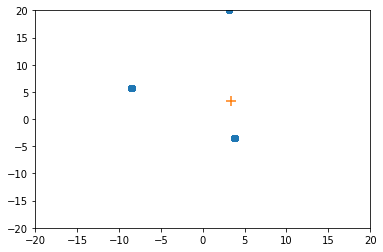

In [218]:
plt.scatter(chain_list[0][1][-1000:,0], chain_list[0][1][-1000:,1])


for i in range(N):
    plt.scatter(kwargs_lens[i+2]['center_x'], kwargs_lens[i+2]['center_x'], marker='+', s=100)
plt.xlim(-20,20)
plt.ylim(-20,20)

In [219]:
xs = chain_list[0][1][-1000:,0]
ys = chain_list[0][1][-1000:,1]

In [223]:
xs_first = xs[xs<-5]
ys_first = ys[xs<-5]

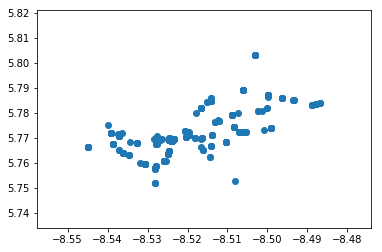

In [224]:
plt.scatter(xs_first, ys_first)

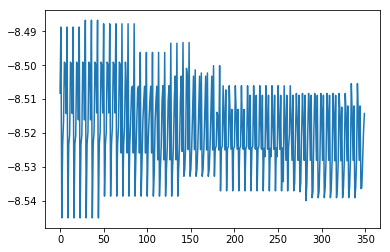

In [230]:
plt.plot(xs_first)

In [231]:
xs_second = xs[ys<0]
ys_second = ys[ys<0]

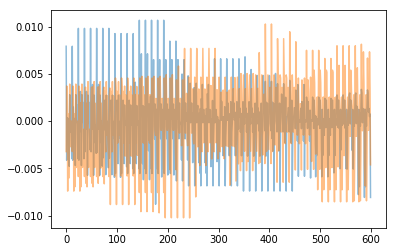

In [235]:
plt.plot(xs_second - np.mean(xs_second), alpha = .5)
plt.plot(ys_second - np.mean(ys_second), alpha = .5)

In [191]:
# for val in range(-10,-1):
#     plt.scatter(chain_list[0][1][val,0], chain_list[0][1][val,1], color='blue')
#     plt.scatter(chain_list[0][1][val,2], chain_list[0][1][val,3], color='blue')
#     plt.scatter(chain_list[0][1][val,4], chain_list[0][1][val,5], color='blue')
#     plt.xlim(-20,20)
#     plt.ylim(-20,20)
#     plt.show()

In [ ]:
plt.scatter(chain_list[0][1][2000:,0], chain_list[0][1][2000:,1])

In [ ]:
plt.scatter(chain_list[0][1][2000:,2], chain_list[0][1][2000:,3])

In [ ]:
plt.scatter(chain_list[0][1][2000:,4], chain_list[0][1][2000:,5])

### Reconstructing the image

In [193]:
def error(image1, image2):
    assert(image1.shape == image2.shape)
    return np.sum((image1 - image2)**2)

In [194]:
lensModel_oneplane = LensModel(lens_model_list=lens_model_list,
                                 z_source=z_source,
                                 multi_plane=False)

imageModel_oneplane = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_oneplane,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        kwargs_numerics=kwargs_numerics)

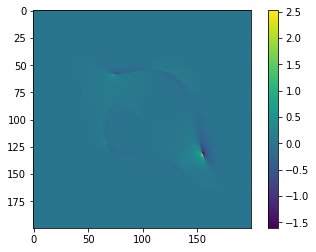

error 123.84735606577428


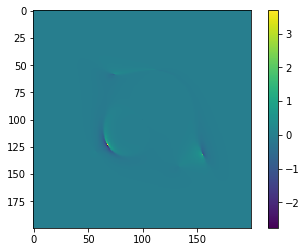

error 198.54119955924182


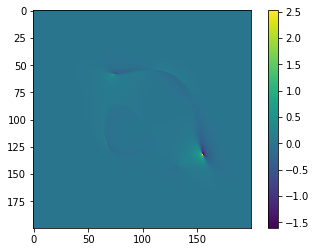

error 123.81608819198728


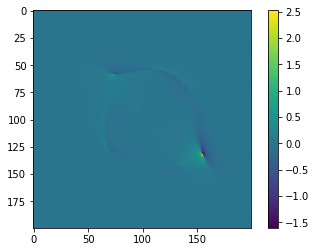

error 123.7382284214129


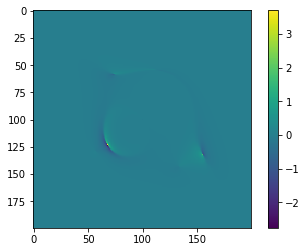

error 198.7753983051258


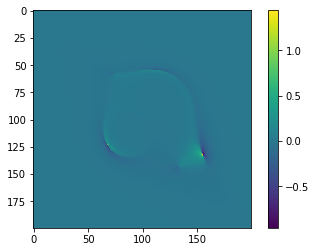

error 49.88780677945815


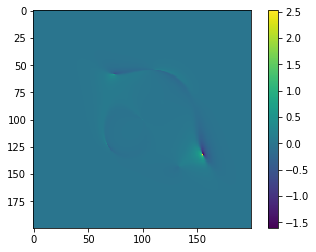

error 123.78878938406001


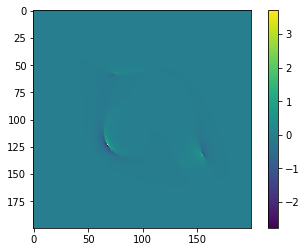

error 199.02770621786505


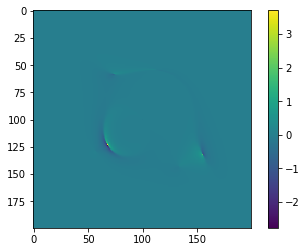

error 199.1243611981396
avg error 148.9496593470072


In [195]:
# Fit to last iteration/walker of MCMC!

kwargs_lens_fit = copy.deepcopy(kwargs_lens)
## just use last value, since they didn't really converge
# chain_list[0][1][val,0], chain_list[0][1][val,1]
error_list = []
for val in range(-10,-1):
    kwargs_lens_fit[2]['center_x'] = np.array(chain_list[0][1][val,0])
    kwargs_lens_fit[2]['center_y'] = np.array(chain_list[0][1][val,1])
#     kwargs_lens_fit[3]['center_x'] = np.array(chain_list[0][1][val,2])
#     kwargs_lens_fit[3]['center_y'] = np.array(chain_list[0][1][val,3])
#     kwargs_lens_fit[4]['center_x'] = np.array(chain_list[0][1][val,4])
#     kwargs_lens_fit[4]['center_y'] = np.array(chain_list[0][1][val,5])

    # simulate image with the "fitted" parameters #
    image_fit = imageModel_oneplane.image(kwargs_lens=kwargs_lens_fit,
                                          kwargs_source=kwargs_light_source,
                                          kwargs_lens_light=kwargs_light_lens)
    #, kwargs_ps=kwargs_ps)

    plt.imshow(image_fit-image); plt.colorbar(); plt.show()
    print('error',error(image, image_fit))
    error_list.append(error(image, image_fit))
print('avg error', np.mean(error_list))

{'center_x_lens2': -0.5415038232994828, 'center_y_lens2': 0.953752956577}


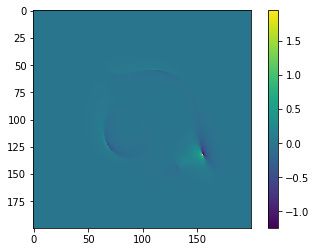

71.0530518579965

In [238]:
# Fit to average of last 100 iterations/walkers of MCMC #

kwargs_lens_fit2 = copy.deepcopy(kwargs_lens)

fitdico = {}
for key, val in zip(chain_list[0][2], chain_list[0][1].T):
    fitdico[key] = np.mean(val[-100:]) # this is arbitrary, of course!
print(fitdico)

kwargs_lens_fit2[2]['center_x'] = np.array(fitdico['center_x_lens2'])
kwargs_lens_fit2[2]['center_y'] = np.array(fitdico['center_y_lens2'])
# kwargs_lens_fit2[3]['center_x'] = np.array(fitdico['center_x_lens3'])
# kwargs_lens_fit2[3]['center_y'] = np.array(fitdico['center_y_lens3'])
# kwargs_lens_fit2[4]['center_x'] = np.array(fitdico['center_x_lens4'])
# kwargs_lens_fit2[4]['center_y'] = np.array(fitdico['center_y_lens4'])

# simulate image with the "fitted" parameters #
image_fit2 = imageModel_oneplane.image(kwargs_lens=kwargs_lens_fit2,
                                      kwargs_source=kwargs_light_source,
                                      kwargs_lens_light=kwargs_light_lens)
#, kwargs_ps=kwargs_ps)

plt.imshow(image_fit2-image); plt.colorbar(); plt.show()
error(image, image_fit2)

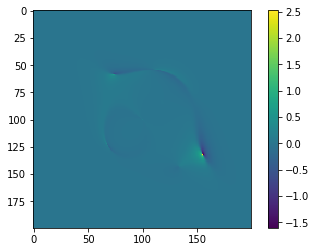

123.82803262940187

In [237]:
# Fit to one "local maximum" of MCMC #

kwargs_lens_fit3 = copy.deepcopy(kwargs_lens)

kwargs_lens_fit3[2]['center_x'] = np.array(np.mean(xs_second))
kwargs_lens_fit3[2]['center_y'] = np.array(np.mean(ys_second

# simulate image with the "fitted" parameters #
image_fit3 = imageModel_oneplane.image(kwargs_lens=kwargs_lens_fit3,
                                      kwargs_source=kwargs_light_source,
                                      kwargs_lens_light=kwargs_light_lens)
#, kwargs_ps=kwargs_ps)

plt.imshow(image_fit3-image); plt.colorbar(); plt.show()
error(image, image_fit3)

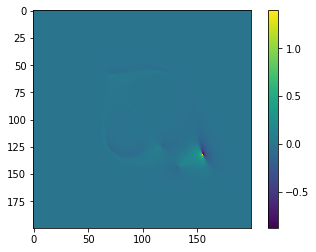

32.57120011565213

In [198]:
# Same parameters but on lens plane #
image_samekwargs = imageModel_oneplane.image(kwargs_lens=kwargs_lens,
                                            kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)

plt.imshow(image_samekwargs-image); plt.colorbar(); plt.show()
error(image, image_samekwargs)

In short, this didn't work...

Where is the optimal $(x,y)$ position of our interloper (holding everything else constant)?

In [ ]:
# Fit to one "local maximum" of MCMC #

kwargs_lens_fit3 = copy.deepcopy(kwargs_lens)
## just use last value, since they didn't really converge
# chain_list[0][1][val,0], chain_list[0][1][val,1]
val = -1 # take last walker iteration
kwargs_lens_fit3[2]['center_x'] = np.array(np.mean(xs_second))
kwargs_lens_fit3[2]['center_y'] = np.array(np.mean(ys_second))
# kwargs_lens_fit2[3]['center_x'] = np.array(fitdico['center_x_lens3'])
# kwargs_lens_fit2[3]['center_y'] = np.array(fitdico['center_y_lens3'])
# kwargs_lens_fit2[4]['center_x'] = np.array(fitdico['center_x_lens4'])
# kwargs_lens_fit2[4]['center_y'] = np.array(fitdico['center_y_lens4'])

# simulate image with the "fitted" parameters #
image_fit3 = imageModel_oneplane.image(kwargs_lens=kwargs_lens_fit3,
                                      kwargs_source=kwargs_light_source,
                                      kwargs_lens_light=kwargs_light_lens)
#, kwargs_ps=kwargs_ps)

plt.imshow(image_fit3-image); plt.colorbar(); plt.show()
error(image, image_fit3)

In [57]:
with open('chains.p', 'rb') as f:
    old_chain_list = pickle.load(f)

(-20, 20)

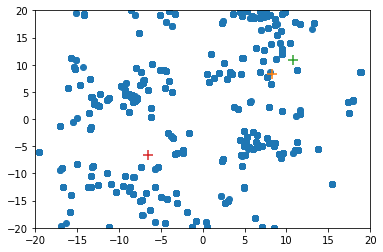

In [84]:
plt.scatter(old_chain_list[0][1][-3000:,0], old_chain_list[0][1][-3000:,1])

for i in range(N):
    plt.scatter(kwargs_lens[i+2]['center_x'], kwargs_lens[i+2]['center_x'], marker='+', s=100)
plt.xlim(-20,20)
plt.ylim(-20,20)

# Fitting Macro-model